## Local Outlier Factors Practice (outlier detection)

 - Scikit-learn

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score

%matplotlib inline

In [4]:
#Example settings

n_samples = 500
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

labels = np.append(np.zeros(n_inliers), np.ones(n_outliers)).astype(int)

In [23]:
## Generate datasets (85% inlier, 15% outlier)

blob_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0,0],[0,0]], cluster_std=0.5, 
              **blob_params)[0],
    make_blobs(centers=[[2,2],[-2,-2]], cluster_std=[0.5, 0.5], 
              **blob_params)[0],
    make_blobs(centers=[[2,2],[-2,-2]], cluster_std=[1.5, .3], 
              **blob_params)[0],
    4. * make_moons(n_samples=n_inliers, noise=.05, random_state=0)[0] -
    np.array([0.5,0.25]),
    14. * (np.random.RandomState(0).rand(n_inliers, 2) - 0.5)
]

def add_outlier(normal_dataset, n_outlier, delta_ratio=0.1, random_state=0):
    max_values = normal_dataset.max(axis=0)
    min_values = normal_dataset.min(axis=0)
    delta = delta_ratio * (max_values - min_values)
    np.random.seed=random_state
    arr_outlier = np.random.uniform(low=min_values - delta, 
                                    high=max_values + delta, 
                                    size=(n_outliers, len(max_values)),
                                   )
    return np.concatenate([normal_dataset, arr_outlier], axis=0)

for n, dataset in enumerate(datasets):
    datasets[n] = add_outlier(dataset, n_outlier=n_outliers)
    
colors = np.array(['#377eb8', '#ff7f00'])

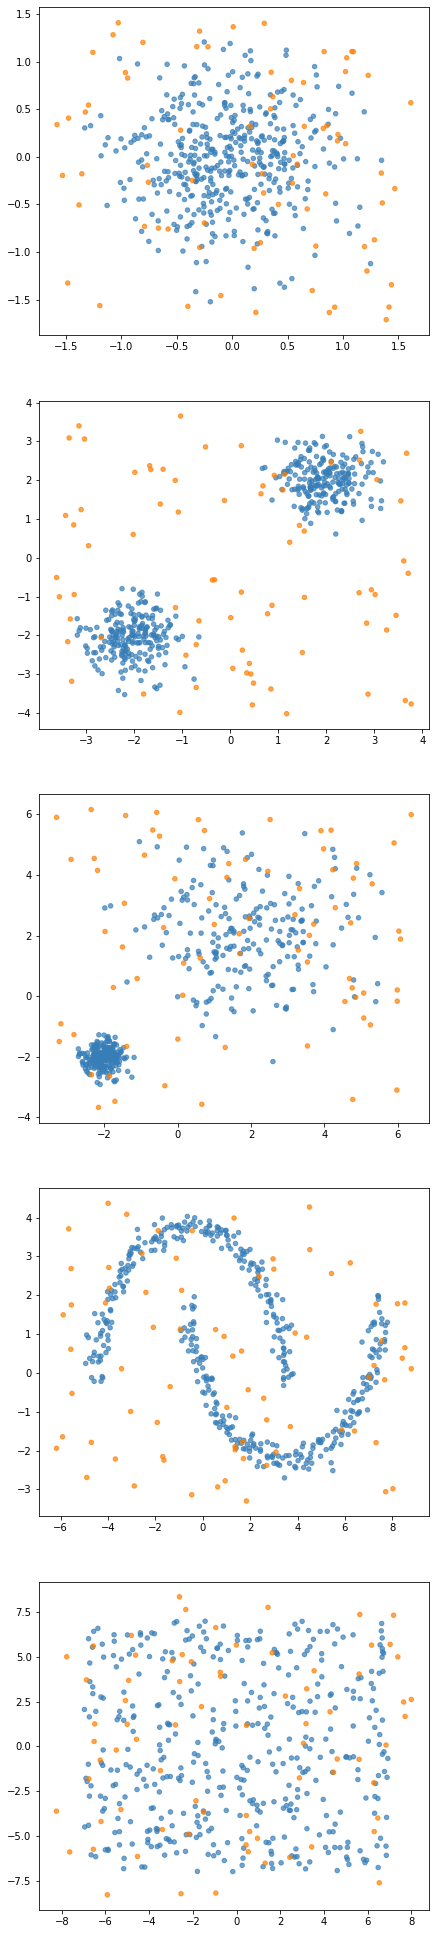

In [25]:
fig, axes = plt.subplots(nrows=len(datasets), ncols=1, figsize=(7, len(datasets)*7))
for n, ax in enumerate(axes):
    ax.scatter(datasets[n][:,0], datasets[n][:,1], color=colors[labels], s=20, alpha=0.7)
    
plt.show()

In [91]:
%%time
# Fit the data to anomaly detection method, 
# Outlier detection
X = datasets[2]

lof = LocalOutlierFactor(contamination=0.15)
y_pred = lof.fit_predict(X)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

CPU times: user 2.81 ms, sys: 837 µs, total: 3.64 ms
Wall time: 2.57 ms


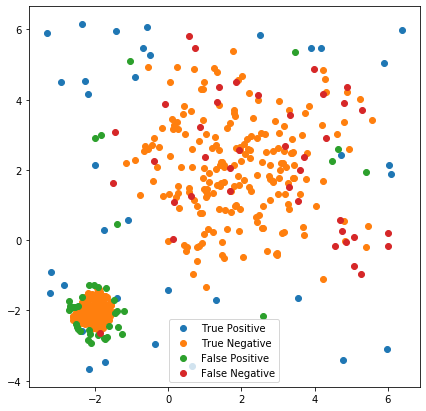

In [92]:
TP = (y_pred==1) & (labels==1) 
TN = (y_pred==0) & (labels==0)
FP = (y_pred==1) & (labels==0) # 오판
FN = (y_pred==0) & (labels==1) # 미검출

plt.figure(figsize=(7,7))
plt.scatter(X[:,0][TP], X[:,1][TP], label='True Positive')
plt.scatter(X[:,0][TN], X[:,1][TN], label='True Negative')
plt.scatter(X[:,0][FP], X[:,1][FP], label='False Positive')
plt.scatter(X[:,0][FN], X[:,1][FN], label='False Negative')
plt.legend()
plt.show()

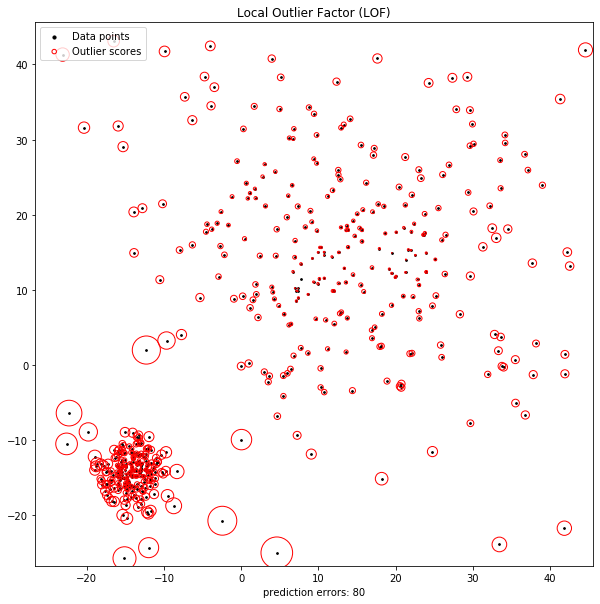

In [93]:
n_error = sum(y_pred != labels)
anomaly_score = lof.negative_outlier_factor_
scale_factor = 7
Z = scale_factor * X
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(Z[:, 0], Z[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (anomaly_score.max() - anomaly_score) / (anomaly_score.max() - anomaly_score.min())
plt.scatter(Z[:, 0], Z[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((np.min(Z)-1, np.max(Z)+1))
plt.ylim((np.min(Z)-1, np.max(Z)+1))
plt.xlabel("prediction errors: %d" % (n_error))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

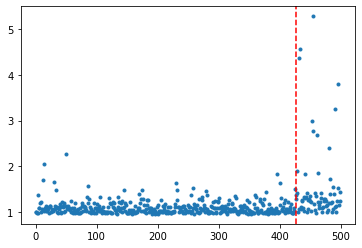

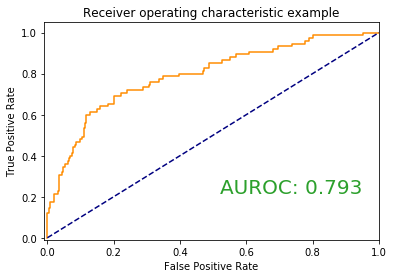

In [94]:
anomaly_score = - lof.negative_outlier_factor_
auroc = roc_auc_score(labels, anomaly_score)

plt.plot(anomaly_score,".")
plt.axvline(x = n_inliers + 1, color='r', linestyle='--', label='normal:abnormal')
plt.show()

x, y , _ = roc_curve(labels, anomaly_score)
plt.plot(x,y, color="darkorange" )
plt.title("Receiver operating characteristic example")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.text(0.95, 0.2, "AUROC: " +str(round(auroc, 3)), {"color": "C2", "fontsize": 20},
va="bottom", ha="right")

plt.xlim([- 0.01, 1.0])
plt.ylim([- 0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


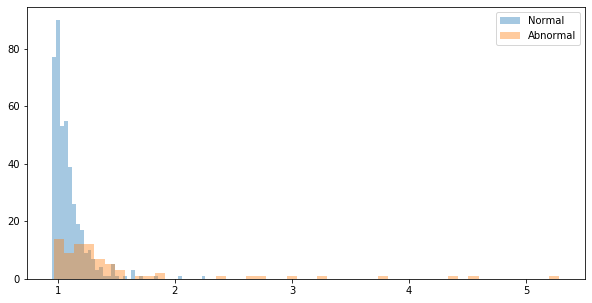

In [97]:
plt.figure(figsize=(10,5))
sns.distplot(anomaly_score[:n_inliers],kde=False, label="Normal")
sns.distplot(anomaly_score[n_inliers:],bins=50, kde=False, label="Abnormal")
plt.legend()

In [96]:
confusion_matrix(y_true=labels, y_pred=y_pred)

array([[385,  40],
       [ 40,  35]])

In [79]:
# for novelty detection